In [198]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [303]:
paths = glob.glob('r.*')
last = sorted(glob.glob('r.*'), key=lambda x : x.lstrip('r.'))[-1] + '/'

runs = []
for file in glob.glob(last + '*.pyT'):
    runs.append(torch.load(file))
    
params = torch.load(last+'params.pkl')
params

{'noise': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
 'lr': [0.01],
 'n': [1000],
 'd': [1],
 'seed': [0],
 'test_noise': [False],
 'loss_type': ['mse'],
 'epsilon': [0.01]}

In [304]:
constraints = {}
#constraints['test_noise'] = True
#constraints['d'] = 1
#constraints['n'] = 100
#constraints['loss_type'] = 'mse'

selected_runs = []
for irun, run in enumerate(runs):
    keep = True
    for k,v in constraints.items():
        if getattr(run['args'],k) != v:
            keep = False
            break
    if keep:
        selected_runs.append(run)
print(len(runs),len(selected_runs))

5 5


Namespace(bs=1000, d=1, depth=1, epochs=1000, epsilon=0.01, loss_type='mse', lr=0.01, max_width=100, min_width=1, mom=0.9, n=1000, n_classes=1, n_test=10000, name='000001', no_cuda=True, noise=0.0031622776601683794, num_widths=20, seed=0, task='regression', teacher_depth=2, teacher_width=100, test_noise=True, var=0.5)
Namespace(bs=1000, d=1, depth=1, epochs=1000, epsilon=0.01, loss_type='mse', lr=0.01, max_width=100, min_width=1, mom=0.9, n=1000, n_classes=1, n_test=10000, name='000004', no_cuda=True, noise=0.1, num_widths=20, seed=0, task='regression', teacher_depth=2, teacher_width=100, test_noise=True, var=0.5)
Namespace(bs=1000, d=1, depth=1, epochs=1000, epsilon=0.01, loss_type='mse', lr=0.01, max_width=100, min_width=1, mom=0.9, n=1000, n_classes=1, n_test=10000, name='000003', no_cuda=True, noise=0.03162277660168379, num_widths=20, seed=0, task='regression', teacher_depth=2, teacher_width=100, test_noise=True, var=0.5)
Namespace(bs=1000, d=1, depth=1, epochs=1000, epsilon=0.01, 

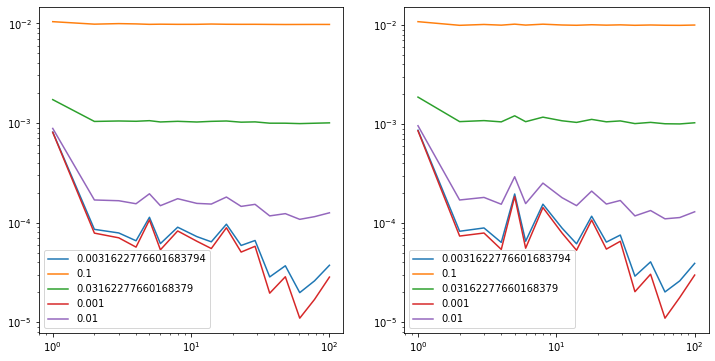

In [305]:
fig, axarr = plt.subplots(1,2, figsize=(12,6))
for run in selected_runs:
    args = run['args']
    print(args)
    widths = run['widths']
    train_losses = run['train_loss']
    test_losses = run['test_loss']
    axarr[0].plot(widths, train_losses,label=args.noise)
    axarr[1].plot(widths, test_losses ,label=args.noise)
for ax in axarr:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

In [208]:
x = torch.from_numpy(np.linspace(1,10,10))
y = torch.from_numpy(np.linspace(1.8,10.2,10))
def hinge_regression(input, target):
    delta = (x-y).abs()-0.5
    loss = F.relu(delta)*delta.pow(2)
    return loss.mean()

hinge_regression(x,y)

tensor(0.0045, dtype=torch.float64)